In [1]:
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

import numpy as np
from matplotlib import pyplot as plt

import cv2
from PIL import Image

import os

%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_data(directory):
    '''
    Load the galaxy images here
    '''
    os.walk(directory)
    res = [x[2] for x in os.walk(directory)]
    res = [file for folder in res for file in folder if '.tif' in file]

    files = sorted(res)[:6000]
    
#     x = np.concatenate([np.array(Image.open(directory + file)).reshape([120,120,1]) for file in files], 2)
#     x_train = x[:, :, :50000]
#     x_test = x[:, :, 50000:]

    x = np.array([np.array(Image.open(directory + file)) for file in files])
    
    x_train = x[:5000] # 5,000
    x_test = x[5000:] # 1,000
    
    return x_train, x_test

In [3]:
# Load data
x_train, x_test = load_data('/floyd/input/denoise_train/')

In [4]:
def noisify_images(images):
    ''' 
    Gaussian-distribution based noise for astronomical images.
    This implementation is vectorized.
    '''
    row,col,idx= images.shape      
    mean = 45.
    var = 150.
    sigma = var**0.5
    gauss = np.array(images.shape)
    gauss = np.random.normal(mean,sigma,(row,col,idx))
    gauss = gauss.reshape(row,col,idx)
    noisy = images + gauss
    noisy = np.clip(noisy, 0., 255.)
    return noisy.astype('uint8')

In [5]:
def denoise_images(images):
    '''
    Nonlocal means denoising and median blur filter
    '''
    return np.array([cv2.medianBlur(cv2.fastNlMeansDenoising(image, None, 9, 13), 5) for image in images])

In [6]:
# Create training dataset
x_train_noisy = noisify_images(x_train)
print('Training set noisified')
# x_train_denoised = denoise_images(x_train)
# print('Training labeles denoised')

# Create testing dataset
x_test_noisy = noisify_images(x_test)
print('Testing set noisified')
# x_test_denoised = denoise_images(x_test)
# print('Testing labeles denoised')

Training set noisified
Testing set noisified


In [7]:
# Normalize datasests
x_train_noisy = x_train_noisy.astype('float32') / 255.
# x_train_denoised = x_train_denoised.astype('float32') / 255.

x_test_noisy = x_test_noisy.astype('float32') / 255.
# x_test_denoised = x_test_denoised.astype('float32') / 255.

In [8]:
#reshape data 
x_train_noisy = x_train_noisy.reshape(x_train_noisy.shape + (1,))
# x_train_denoised = x_train_denoised.reshape(x_train_denoised.shape + (1,))

x_test_noisy = x_test_noisy.reshape(x_test_noisy.shape + (1,))
# x_test_denoised = x_test_denoised.reshape(x_test_denoised.shape + (1,))

In [9]:
input_img = Input(shape=(120, 120, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 60, 60, 32)        0         
__________

In [47]:
history = autoencoder.fit(x_train_noisy, x_train_denoised,
                epochs=20,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test_noisy, x_test_denoised),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False), ModelCheckpoint(filepath='2layer_weights.h5', verbose=1, save_best_only=True)])

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 8s 2ms/step - loss: 0.4003 - val_loss: 0.3639

Epoch 00001: val_loss improved from inf to 0.36395, saving model to 2layer_weights.h5
Epoch 2/20
5000/5000 [==============================] - 7s 1ms/step - loss: 0.3647 - val_loss: 0.3650

Epoch 00002: val_loss did not improve from 0.36395
Epoch 3/20
5000/5000 [==============================] - 7s 1ms/step - loss: 0.3623 - val_loss: 0.3610

Epoch 00003: val_loss improved from 0.36395 to 0.36096, saving model to 2layer_weights.h5
Epoch 4/20
5000/5000 [==============================] - 7s 1ms/step - loss: 0.3607 - val_loss: 0.3598

Epoch 00004: val_loss improved from 0.36096 to 0.35984, saving model to 2layer_weights.h5
Epoch 5/20
5000/5000 [==============================] - 7s 1ms/step - loss: 0.3602 - val_loss: 0.3598

Epoch 00005: val_loss improved from 0.35984 to 0.35980, saving model to 2layer_weights.h5
Epoch 6/20
5000/5000 [========

Text(0.5,1,'7200 feature embedding')

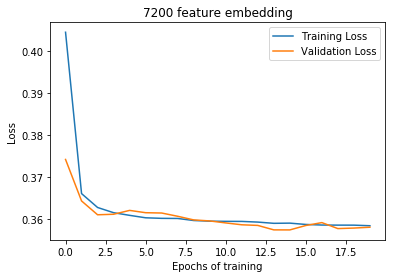

In [45]:
# plt.plot((history.history['val_loss'], history.history['loss']))
# history, weights.h5 # 0.35747 extra conv 7200 latent space
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel("Epochs of training")
plt.ylabel("Loss")
plt.title("7200 feature embedding")

Text(0.5,1,'28800 feature embedding')

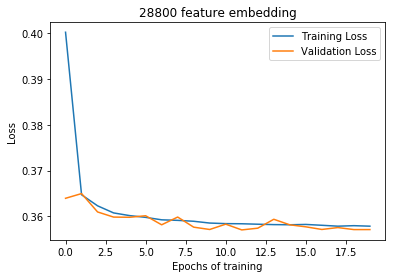

In [216]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel("Epochs of training")
plt.ylabel("Loss")
plt.title("28800 feature embedding")

In [10]:
autoencoder.load_weights("2layer_weights.h5")

In [11]:
denoised_images = autoencoder.predict(x_test_noisy)

In [12]:
denoised_images.shape

(1000, 120, 120, 1)

In [13]:
# Starting Point
n = 21

In [14]:
def plot_images(ten_images):
    plt.figure(figsize=(20, 5))
    for i in range(0,10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(ten_images[i].reshape(120,120))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

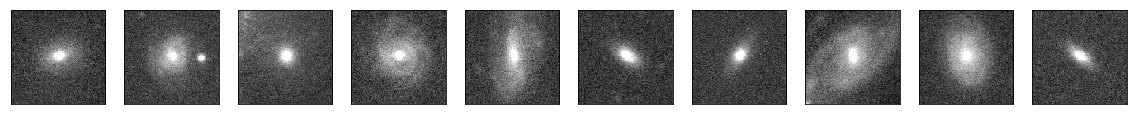

In [15]:
plot_images(x_test_noisy[n-10:n])

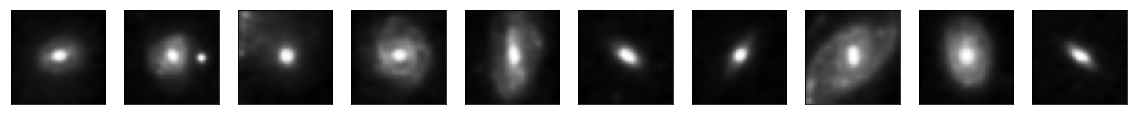

In [16]:
plot_images(denoised_images[n-10:n])

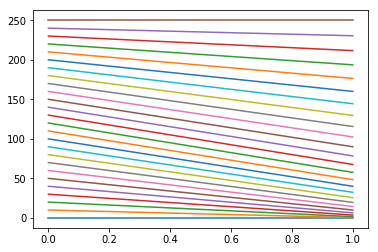

In [17]:
a = np.array([0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250])
b = a**2/250.
fig = plt.plot((a,b))

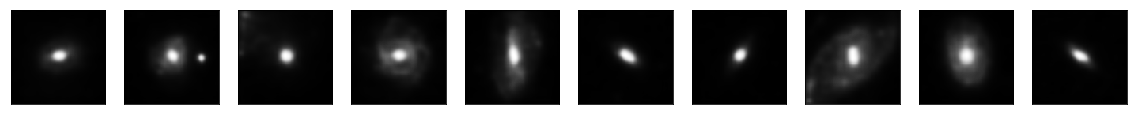

In [52]:
test_images = np.square(denoised_images[n-10:n])#/255.
plot_images(test_images)

In [53]:
import scipy
from scipy import ndimage

def sharpen_images(images):
    sharpened_images=[]
    for f in images:
        blurred_f = ndimage.gaussian_filter(f, 3)
        filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
        alpha = 5
        sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)
        sharpened_images.append(sharpened)
    return np.array(sharpened_images)

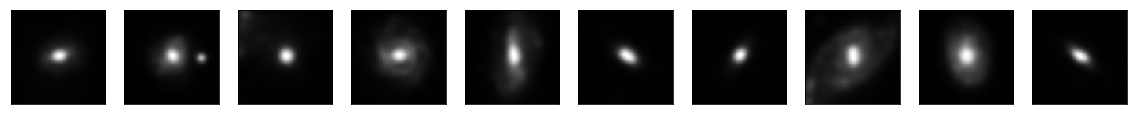

In [54]:
plot_images(sharpen_images(test_images))

In [55]:
from scipy import ndimage

def sobel_edges(images):
    sobel_images = []
    for f in images:
        # Use a gradient operator (Sobel) to find high intensity variations:
        sx = ndimage.sobel(f, axis=0, mode='constant')
        sy = ndimage.sobel(f, axis=1, mode='constant')
        sob = np.hypot(sx, sy)
        sobel_images.append(sob)
    return np.array(sobel_images)

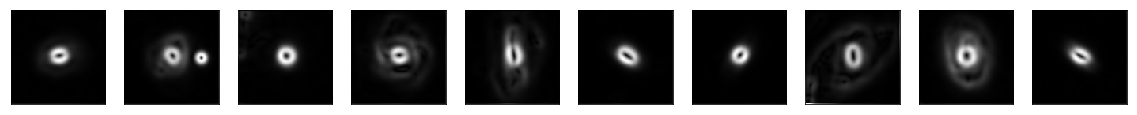

In [56]:
plot_images(sobel_edges(sharpen_images(test_images)))

In [57]:
def donut_fill(preprocessed, postprocessed, window_size=5, threshold=4000, pad_fill=1):
        
    corrected = []
    
    # Loop through each preprocessed image
    for idx, img in enumerate(preprocessed):
        
        mask = np.zeros(img.shape)
        padding = window_size//2
        max_ = np.max(img)
        
        for i in range(window_size, img.shape[0] - window_size):
            for j in range(window_size, img.shape[1] - window_size):
                if np.sum(img[i-padding : i+padding+1, j-padding : j+padding+1]) >= threshold:
                    mask[i-pad_fill:i+pad_fill,j-pad_fill:j+pad_fill] = max_
        
        corrected.append(np.clip(postprocessed[idx] + mask, 0.0, max_))
    
    return np.array(corrected)

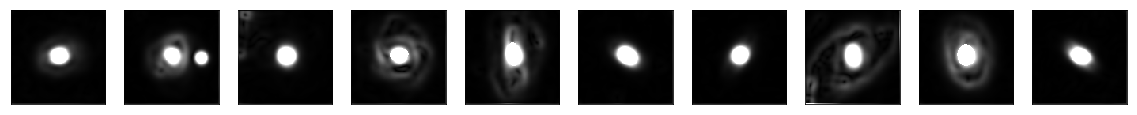

In [64]:
preprocessed = sharpen_images(test_images)
postprocessed = sobel_edges(preprocessed)

# corrected_pre = np.array([img * (255/np.max(img)) for img in preprocessed])
# corrected_post = np.array([img * (255/np.max(img)) for img in postprocessed])
donut_filling = donut_fill(preprocessed, postprocessed, threshold=10)
plot_images(donut_filling)

In [65]:
from skimage import feature

def canny_edges(images):
    return np.array([feature.canny(img.reshape(120,120)) for img in images])

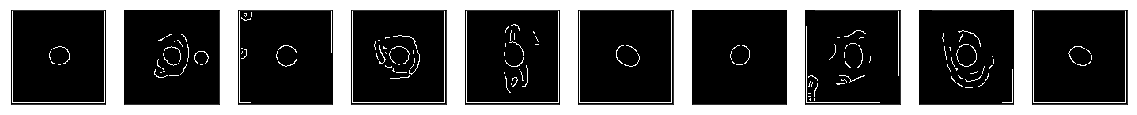

In [66]:
plot_images(canny_edges(donut_filling))

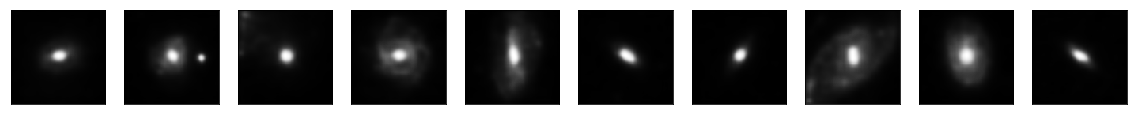

In [67]:
plot_images(test_images)

In [28]:
def highlight_features(images):
    response = []
    for img in images:
        max_ = np.max(img)
        new = img + img
        highlighted = np.clip(new, 0.0, max_)
        response.append(highlighted)
    return np.array(response)

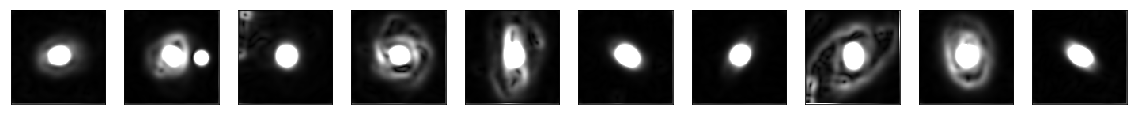

In [29]:
plot_images(highlight_features(donut_filling))

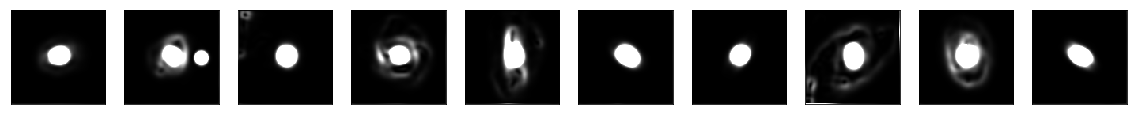

In [30]:
plot_images(highlight_features(donut_filling) ** 2)

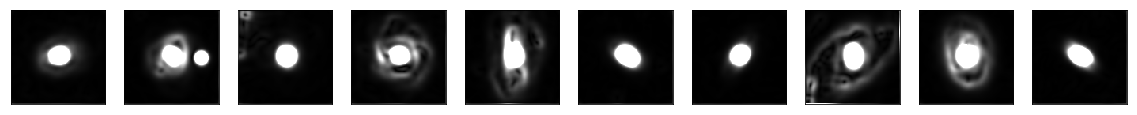

In [31]:
plot_images((highlight_features(donut_filling) ** 2) + highlight_features(donut_filling))

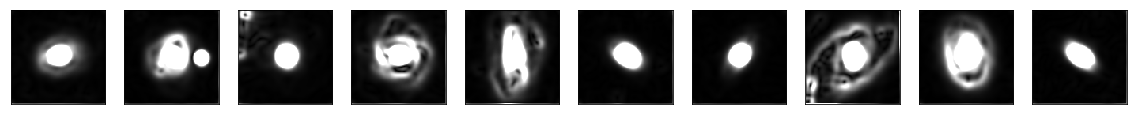

In [32]:
plot_images(highlight_features((highlight_features(donut_filling) ** 2) + highlight_features(donut_filling)))

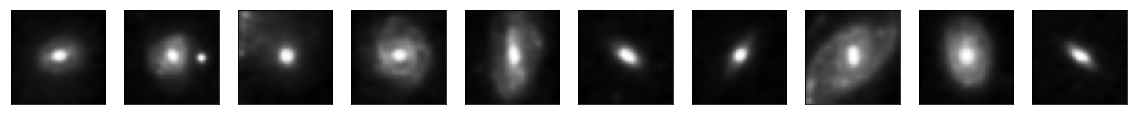

In [35]:
plot_images(denoised_images[n-10:n])

# Procedure without squaring values

In [36]:
test_images = denoised_images[n-10:n]

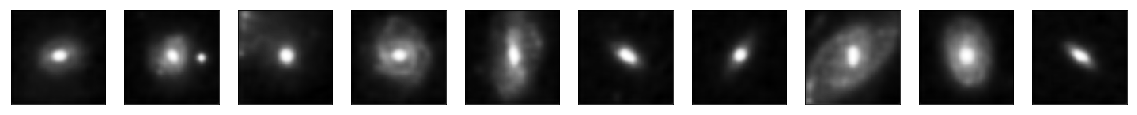

In [32]:
plot_images(test_images)

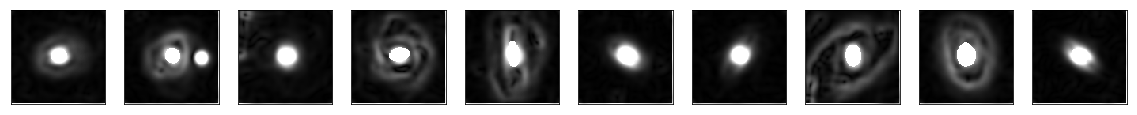

In [37]:
preprocessed = sharpen_images(test_images)
postprocessed = sobel_edges(preprocessed)

donut_filling = donut_fill(preprocessed, postprocessed, threshold=15)
plot_images(donut_filling)

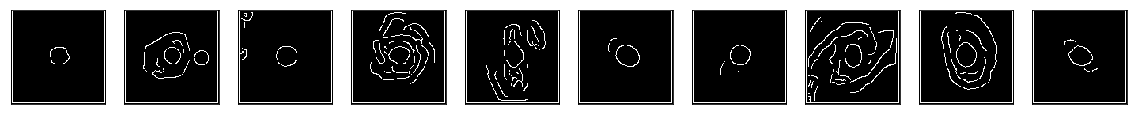

In [38]:
plot_images(canny_edges(donut_filling))

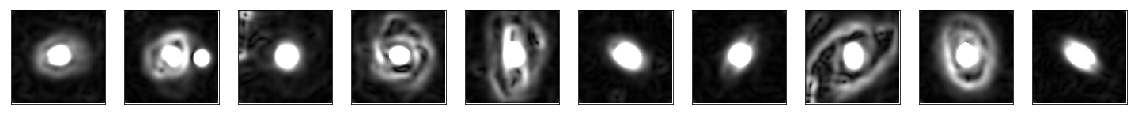

In [39]:
plot_images(highlight_features(donut_filling))

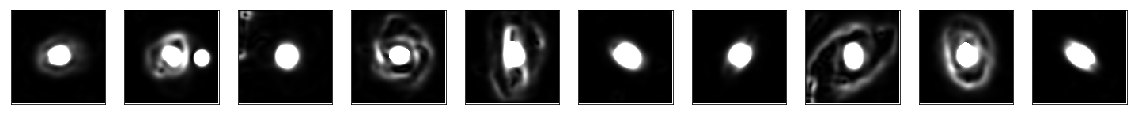

In [40]:
plot_images(highlight_features(donut_filling) ** 2)

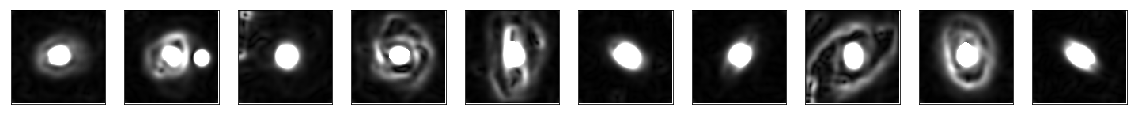

In [41]:
plot_images((highlight_features(donut_filling) ** 2) + highlight_features(donut_filling))

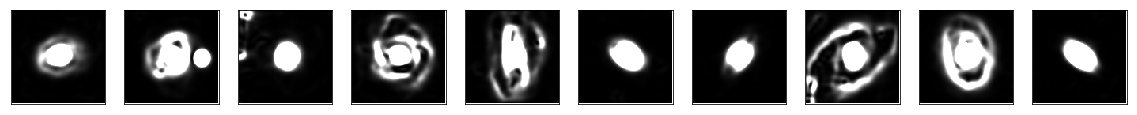

In [43]:
plot_images(highlight_features((highlight_features(donut_filling) ** 2) + highlight_features(donut_filling))**2)

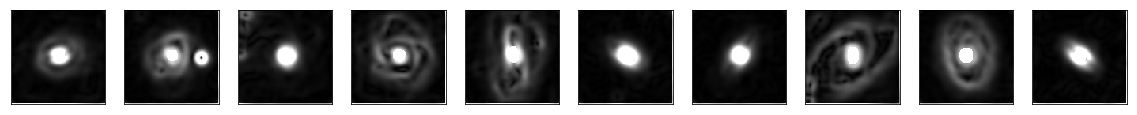

In [34]:
preprocessed = sharpen_images(test_images)
postprocessed = sobel_edges(preprocessed)

donut_filling = donut_fill(preprocessed, postprocessed, threshold=20, pad_fill=3)
plot_images(donut_filling)

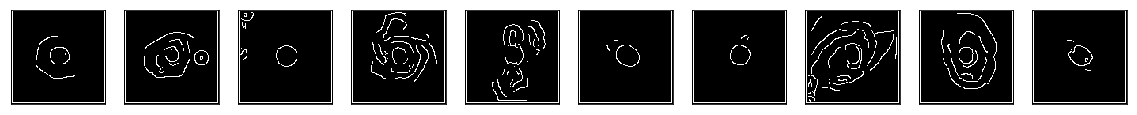

In [35]:
plot_images(canny_edges(donut_filling))

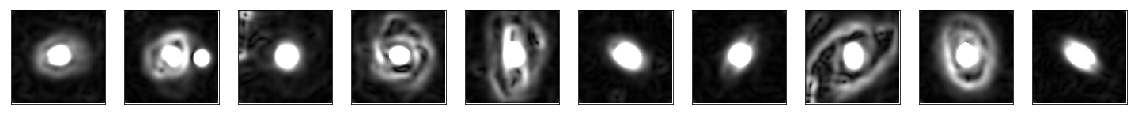

In [44]:
plot_images(highlight_features(donut_filling))

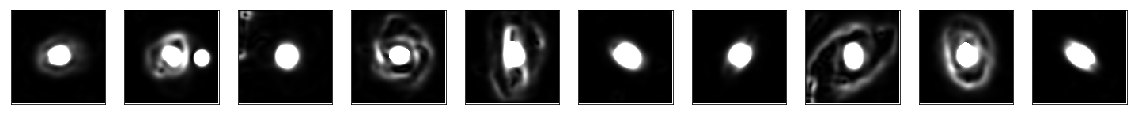

In [45]:
plot_images(highlight_features(donut_filling) ** 2)

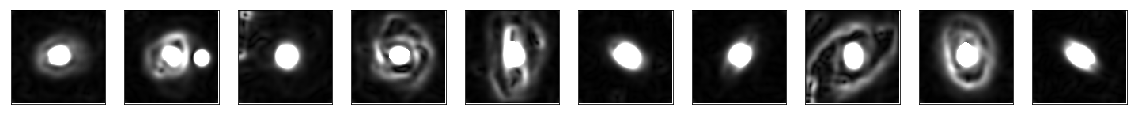

In [46]:
plot_images((highlight_features(donut_filling) ** 2) + highlight_features(donut_filling))